In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal

## Import data and calculate GF

In [2]:
#define our output grid size

ds_nbp_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.625, 360., 1.25)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(0, 361, 1.25))
    }
)

A_nbp = utils.find_area(ds_nbp_out, R = 6.3781e6) #convert to m2

In [3]:
#define our output grid size

ds_fgco2_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.5, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

A_fgco2 = utils.find_area(ds_fgco2_out, R = 6.3781e6) #convert to m2

In [4]:
model_run_1pct_dict = utils.model_run_1pct_dict
model_run_control_dict = utils.model_run_picontrol_dict


In [5]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)
A = utils.find_area(ds_out, R = 6.3781e6)

In [6]:
fg_co2_1pct = {}
fg_co2_pictrl = {}
nbp_1pct = {}
nbp_pictrl = {}
co2_1pct = {}
co2_pictrl = {}

In [7]:
for m in model_run_1pct_dict.keys():
    print(m)
    print('load 1pct run')
   
    #print('fgco2')
    fg_co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_1pct_dict[m]}', use_cftime=True) #kg/m2/s
    fg_co2_1pct[m] = utils._regrid_ds(fg_co2_1pct[m], ds_out)

    #print('nbp')
    nbp_1pct[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_1pct_dict[m]}', use_cftime=True) #kg/m2/s
    nbp_1pct[m] = utils._regrid_ds(nbp_1pct[m], ds_out)

    if m == 'UKESM1_r1' or m == 'UKESM1_r2' or m == 'UKESM1_r3' or m == 'UKESM1_r4' or m == 'NORESM2' or m == 'GFDL':
        #print('co2mass')
        co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_1pct_dict[m]}', use_cftime=True) #kg

UKESM1_r1
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r2
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r3
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r4
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MIROC
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


NORESM2
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


ACCESS
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


GFDL
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p2
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p2
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p2
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p1
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p1
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p1
load 1pct run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [8]:
for m in model_run_control_dict.keys():
    print(m)
    print('load pi control run')
    fg_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg/m2/s
    fg_co2_pictrl[m] = utils._regrid_ds(fg_co2_pictrl[m], ds_out)
    nbp_pictrl[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg/m2/s
    nbp_pictrl[m] = utils._regrid_ds(nbp_pictrl[m], ds_out)

    if m == 'UKESM1_r1' or m == 'NORESM2' or m == 'GFDL':
        co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg



UKESM1_r1
load pi control run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MIROC
load pi control run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


NORESM2
load pi control run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


ACCESS
load pi control run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


GFDL
load pi control run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p2
load pi control run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p1
load pi control run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


control = {}
pulse = {}
G = {}

for m1 in model_run_1pct_dict.keys():
    print(m1)
    if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m == 'UKESM1_r4':
        m2 = 'UKESM1'
    elif m1 == 'CANESM5_r1' or m1 == 'CANESM5_r2' or m1 == 'CANESM5_r3' or m1 == 'CANESM5_r4' or m1 == 'CANESM5_r5':
        m2 = 'CANESM5'
    else:
        m2 = m1
    print(m2)
    control[m], pulse[m], G[m] = utils.import_regrid_calc(f'cmip6_data/tas_Amon_{model_run_control_dict[m2]}', 
                                                 f'cmip6_data/tas_Amon_{model_run_pulse_dict[m1]}', 
                                                 ds_out, variable = 'tas', pulse_size = 100)

### Notes:

GFDL: 1pct and esm pi-control start from year 0001

UKESM1: 1pct starts in 1850 and pi-control starts in 1960, move 1pct to start in 1960

MIROC: both start from 1850

NORESM2: 1pct from 0001 pi-control from 1600-- move 1pct to 1600

ACCESS: 1pct and pi-control from 0101

CANESM5_r1p2: 1pct 1850, pi-control 5550, move 1pct to 5550


In [9]:
#convert kg to kg/year
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2', 'GFDL']:
    seconds_per_yr = 60*60*24*365
    co2_1pct[m]['G_atm'] = co2_1pct[m]['co2mass'].diff('time')/(co2_1pct[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
    
for m in [ 'NORESM2', 'GFDL', 'UKESM1_r1']:
    seconds_per_yr = 60*60*24*365
    co2_pictrl[m]['G_atm'] = co2_pictrl[m]['co2mass'].diff('time')/(co2_pictrl[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr

In [10]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [11]:
## fix the times so that they line up according to the notes above
m = 'NORESM2'
nbp_1pct[m]['time'] = nbp_pictrl[m]['time'][:len(nbp_1pct[m]['time'])]
fg_co2_1pct[m]['time'] = fg_co2_pictrl[m]['time'][:len(fg_co2_1pct[m]['time'])]
co2_1pct[m]['time'] = co2_pictrl[m]['time'][:len(co2_1pct[m]['time'])]
co2_1pct[m] *=1.5172413793 #currently saved as the vmr (see the attributes, has not been properly converted)
co2_pictrl[m] *=1.5172413793 #currently saved as the vmr (see the attributes, has not been properly converted)


for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4']:
    nbp_1pct[m]['time'] = nbp_pictrl['UKESM1_r1']['time'][:len(nbp_1pct[m]['time'])]
    fg_co2_1pct[m]['time'] = fg_co2_pictrl['UKESM1_r1']['time'][:len(fg_co2_1pct[m]['time'])]
    co2_1pct[m]['time'] = co2_pictrl['UKESM1_r1']['time'][:len(co2_1pct[m]['time'])]

for m in ['CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2']:
    nbp_1pct[m]['time'] = nbp_pictrl['CANESM5_r1p2']['time'][:len(nbp_1pct[m]['time'])]
    fg_co2_1pct[m]['time'] = fg_co2_pictrl['CANESM5_r1p2']['time'][:len(fg_co2_1pct[m]['time'])]

for m in [ 'CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1']:
    nbp_1pct[m]['time'] = nbp_pictrl['CANESM5_r1p1']['time'][:len(nbp_1pct[m]['time'])]
    fg_co2_1pct[m]['time'] = fg_co2_pictrl['CANESM5_r1p1']['time'][:len(fg_co2_1pct[m]['time'])]
    

In [12]:
fg_co2 = {}
nbp = {}

for m1 in model_run_1pct_dict.keys():
    print(m1)
    if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
        m2 = 'UKESM1_r1'
    elif m1 == 'CANESM5_r1p1' or m1 == 'CANESM5_r2p1' or m1 == 'CANESM5_r3p1':
         m2 = 'CANESM5_r1p1'
    elif m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r3p2':
         m2 = 'CANESM5_r1p2'
    else:
        m2 = m1
    print(m1, m2)
    fg_co2[m1] = fg_co2_1pct[m1] - fg_co2_pictrl[m2]
    nbp[m1] = nbp_1pct[m1] - nbp_pictrl[m2]
    fg_co2[m1]['fgco2'] = fg_co2[m1]['fgco2']*seconds_per_yr*A
    nbp[m1]['nbp'] = nbp[m1]['nbp']*seconds_per_yr*A

UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r2
UKESM1_r2 UKESM1_r1
UKESM1_r3
UKESM1_r3 UKESM1_r1
UKESM1_r4
UKESM1_r4 UKESM1_r1
MIROC
MIROC MIROC
NORESM2
NORESM2 NORESM2
ACCESS
ACCESS ACCESS
GFDL
GFDL GFDL
CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r2p2
CANESM5_r2p2 CANESM5_r1p2
CANESM5_r3p2
CANESM5_r3p2 CANESM5_r1p2
CANESM5_r1p1
CANESM5_r1p1 CANESM5_r1p1
CANESM5_r2p1
CANESM5_r2p1 CANESM5_r1p1
CANESM5_r3p1
CANESM5_r3p1 CANESM5_r1p1


In [13]:
co2_dif = {}
for m1 in co2_1pct.keys():
    if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
        m2 = 'UKESM1_r1'
    else:
        m2 = m1
    print(m1, m2)
    co2_dif[m1] = co2_1pct[m1]['G_atm'] - co2_pictrl[m2]['G_atm'] #kg/yr

UKESM1_r1 UKESM1_r1
UKESM1_r2 UKESM1_r1
UKESM1_r3 UKESM1_r1
UKESM1_r4 UKESM1_r1
NORESM2 NORESM2
GFDL GFDL


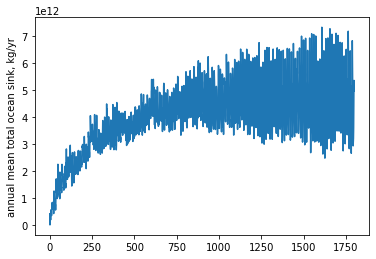

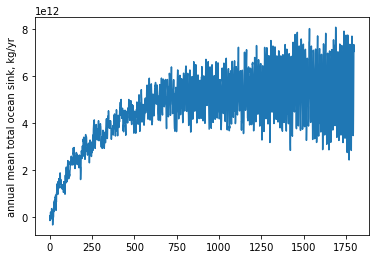

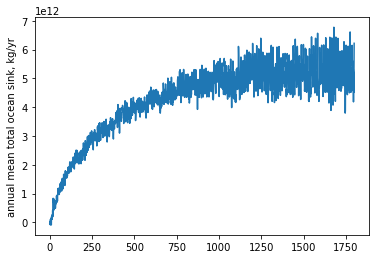

In [14]:
for m in ['UKESM1_r2', 'GFDL', 'NORESM2']:#model_run_1pct_dict.keys():
    fig, ax = plt.subplots()
    plt.plot(fg_co2[m]['fgco2'].sum(dim = ['lat','lon']))
    plt.ylabel('annual mean total ocean sink, kg/yr')

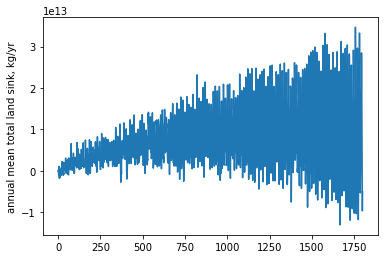

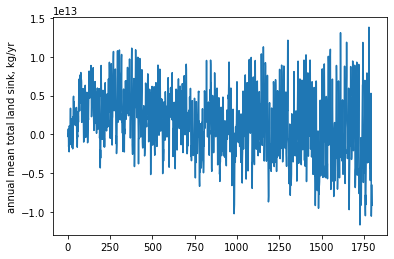

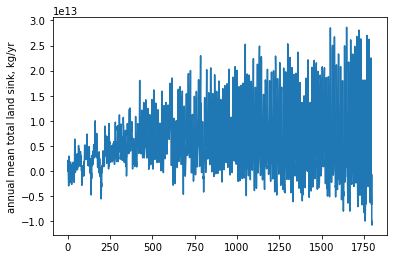

In [25]:
for m in [ 'NORESM2', 'ACCESS','MIROC']: #model_run_control_dict.keys():
    fig, ax = plt.subplots()
    plt.plot(nbp[m]['nbp'].sum(dim = ['lat','lon']))
    plt.ylabel('annual mean total land sink, kg/yr')

In [15]:
#total sinks

emis_sinks = {}
for m in nbp.keys():
    emis_sinks[m] = nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['lat','lon'])

In [16]:
#fix the times to all be the same, weight by month and take the mean

for m in nbp.keys():
    times = pd.date_range('2000', periods=len(emis_sinks[m]['time']), freq='MS')
    weights = times.shift(1, 'MS') - times
    weights = xr.DataArray(weights, [('time', emis_sinks[m]['time'].values)]).astype('float')
    emis_sinks[m] =  (emis_sinks[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


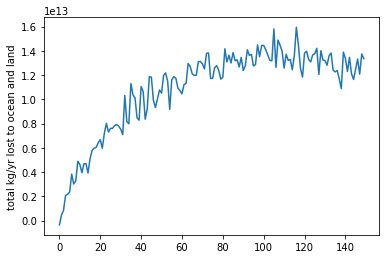

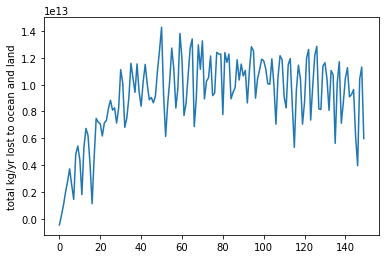

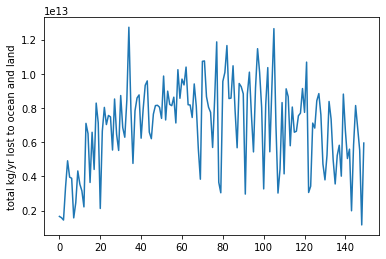

In [28]:
for m in ['NORESM2','MIROC','UKESM1_r1']:
    fig, ax = plt.subplots()
    plt.plot(emis_sinks[m])
    plt.ylabel('total kg/yr lost to ocean and land')

In [17]:
G_atm = {}
for m in co2_dif.keys():

    times = pd.date_range('2000', periods=len(co2_dif[m]['time']), freq='MS')
    weights = times.shift(1, 'MS') - times
    weights = xr.DataArray(weights, [('time', co2_dif[m]['time'].values)]).astype('float')

    G_atm[m] = (co2_dif[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


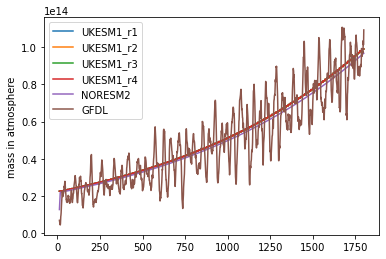

In [18]:
fig, ax = plt.subplots()
for m in co2_dif.keys():
    plt.plot(co2_dif[m].rolling(time = 12).mean(), label = m)
    plt.ylabel('mass in atmosphere')
    plt.legend()

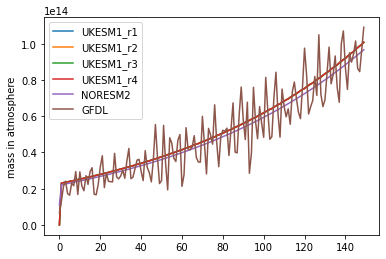

In [19]:
fig, ax = plt.subplots()
for m in G_atm.keys():
    plt.plot(G_atm[m], label = m)
    plt.ylabel('mass in atmosphere')
    plt.legend()

In [20]:
for m in emis_sinks.keys():
    emis_sinks[m]['year'] = np.arange(0, len(emis_sinks[m]['year']))

In [21]:
for m in G_atm.keys():
    G_atm[m]['year'] = np.arange(0, len(G_atm[m]['year']))

In [22]:
emis_co2 = {}
emis_co2_rolling10 = {}
emis_co2_rolling20 = {}

for m in G_atm.keys():
        emis_co2[m] = G_atm[m] + emis_sinks[m]
        #emis_co2_rolling10[m] = emis_co2[m].rolling(year = 10).mean(center = True).dropna("year") #G_atm[m].rolling(year = 10).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 10).mean(center = True).dropna("year")
        #emis_co2_rolling20[m] = emis_co2[m].rolling(year = 20).mean(center = True).dropna("year") #G_atm[m].rolling(year = 20).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 20).mean(center = True).dropna("year")


In [23]:
def diff(list1, list2):
    return list(set(list1).symmetric_difference(set(list2)))  # or return list(set(list1) ^ set(list2))



In [24]:
for m in diff(emis_sinks.keys(), G_atm.keys()):
        emis_co2[m] = G_atm['GFDL'] + emis_sinks[m] #use GFDL co2 mass bc these runs don't have their own
        #emis_co2_rolling10[m] = emis_co2[m].rolling(year = 10).mean(center = True).dropna("year") #G_atm['UKESM1'].rolling(year = 10).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 10).mean(center = True).dropna("year")
        #emis_co2_rolling20[m] = emis_co2[m].rolling(year = 20).mean(center = True).dropna("year") #G_atm['UKESM1'].rolling(year = 20).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 20).mean(center = True).dropna("year")
    
    

In [25]:
kg_CO2_to_GtC = 1/(1e12*3.67)

In [26]:
emis_co2_GtC = {}
emis_co2_GtC_rolling10 = {}
emis_co2_GtC_rolling20 = {}

for m in emis_co2.keys():
    emis_co2_GtC[m] = emis_co2[m]*kg_CO2_to_GtC
    #emis_co2_GtC_rolling10[m] = emis_co2_rolling10[m]*kg_CO2_to_GtC
    #emis_co2_GtC_rolling20[m] = emis_co2_rolling20[m]*kg_CO2_to_GtC

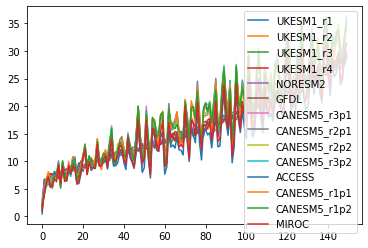

In [104]:
fig, ax = plt.subplots()
for m in emis_co2_GtC.keys():
    plt.plot(emis_co2_GtC[m], label = m) #Gt/yr
   # plt.plot(emis_co2_GtC_rolling10[m]) #Gt/yr
   # plt.plot(emis_co2_GtC_rolling20[m]) #Gt/yr
    plt.legend()

In [27]:
emis_co2_GtC_ds = xr.concat([emis_co2_GtC[m] for m in emis_co2_GtC.keys()], pd.Index([m for m in emis_co2_GtC.keys()], name='model'), coords='minimal')
#emis_co2_GtC_rolling10_ds = xr.concat([emis_co2_GtC_rolling10[m] for m in emis_co2_GtC_rolling10.keys()], pd.Index([m for m in emis_co2_GtC_rolling10.keys()], name='model'), coords='minimal')
#emis_co2_GtC_rolling20_ds = xr.concat([emis_co2_GtC_rolling20[m] for m in emis_co2_GtC_rolling20.keys()], pd.Index([m for m in emis_co2_GtC_rolling20.keys()], name='model'), coords='minimal')


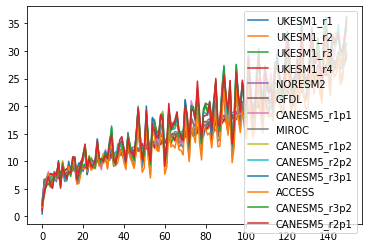

In [32]:
for m in emis_co2_GtC_ds.model.values:
    plt.plot(emis_co2_GtC_ds.sel(model = m), label = m)
    plt.legend()

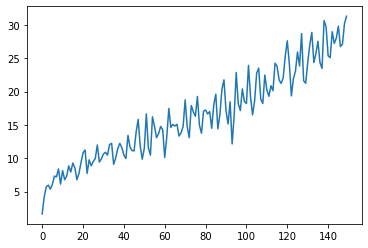

In [31]:
plt.plot(emis_co2_GtC_ds.sel(model = "GFDL"))

# Save out CO2 emissions

In [29]:
emis_co2_GtC_ds.to_netcdf('1pct_emis_profile_full.nc4')


#np.savetxt('1pct_emis_profile_derived.csv', np.array(list(E_base.values())), delimiter=',')
#np.savetxt('1pct_emis_profile_rcp85.csv', np.array(list(E_85.values())), delimiter=',')
np.savetxt('1pct_emis_profile.csv', np.array(emis_co2_GtC_ds))
np.savetxt('1pct_emis_profile_rolling10.csv', np.array(emis_co2_GtC_rolling10_ds))
np.savetxt('1pct_emis_profile_rolling20.csv', np.array(emis_co2_GtC_rolling20_ds))

emis_co2_GtC_rolling10_ds.to_netcdf('1pct_emis_profile_rolling10.nc4')
emis_co2_GtC_rolling20_ds.to_netcdf('1pct_emis_profile_rolling20.nc4')